## Install Weights and Biases

In [1]:
# WandB – Install the W&B library
!pip install wandb -q

     |████████████████████████████████| 1.7 MB 5.6 MB/s 
     |████████████████████████████████| 180 kB 44.6 MB/s 
     |████████████████████████████████| 140 kB 44.2 MB/s 
     |████████████████████████████████| 97 kB 5.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 


## Imports

In [2]:
import os
import glob as glob
import cv2
import matplotlib.pyplot as plt
import requests
import zipfile

# WandB – Import the wandb library
import wandb

## Set Up Weights and Biases for Logging
We use the YOLOv5 model from the Ultralytics repository which automatically logs all the plots and result metrics to Weights and Biases. But we need to set a few things before we start the training for the automatic logging to happen correctly.

Before executing the following cell, make sure that you have a Weights and Biases Account. You can create an account **[here](https://wandb.auth0.com/login?state=hKFo2SA5VU5rZ3BDMEVpeE4tMlNhbmIxTzR2a0daOGk4ZmpwRaFupWxvZ2luo3RpZNkgOVBWWFpkOGhZZHdHcG5TMXhGcE9melR4eUh1NmRSelWjY2lk2SBWU001N1VDd1Q5d2JHU3hLdEVER1FISUtBQkhwcHpJdw&client=VSM57UCwT9wbGSxKtEDGQHIKABHppzIw&protocol=oauth2&nonce=losScwmdz1rvYA_JseyDYg%3D%3D&redirect_uri=https%3A%2F%2Fapi.wandb.ai%2Foidc%2Fcallback&response_mode=form_post&response_type=id_token&scope=openid%20profile%20email&signup=true)**.

You will need an API key of your account. After creating an account and logging in, you can find you API key in <font color="green">**Settings => API Keys** </font> section. Fow now copy that API key and copy and paste in the output prompt after executing the next cell.

In [3]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


That's it, now we can start the training and everything will be logged to Weights and Biases automatically.

## Constant/Config Setup

In [4]:
# Whether to carry out training or not,
# if `false`, running the whole notebook will carry out
# inference on the last trained model automatically
TRAIN = True
# Number of epochs to train for.
EPOCHS = 50

## Ultralytics Setup

In [5]:
#### RUN THIS ONCE TO CLONE THE YOLOV5 REPO ####
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 10354, done.
remote: Total 10354 (delta 0), reused 0 (delta 0), pack-reused 10354
Receiving objects: 100% (10354/10354), 10.57 MiB | 24.54 MiB/s, done.
Resolving deltas: 100% (7147/7147), done.


In [6]:
%cd yolov5/

/content/yolov5


In [7]:
!pwd

/content/yolov5


## Dataset Download

Here, we will download the Snowman dataset images and labels. The two folders that will be downloaded will contain all the images and labels that we need.

In [8]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)

        open(save_name, 'wb').write(file.content)
    
download_file('https://learnopencv.s3.us-west-2.amazonaws.com/snowman-dataset.zip', 'snowman_dataset.zip')

In [9]:
zip_file = 'snowman_dataset.zip'

if not os.path.exists('JPEGImages_and_Labels'):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

Extracted all


## Prepare Final Dataset in YOLOv5 Format

In [10]:
# Create an `images` and a `labels` directory in `snowman_data`.
os.makedirs('snowman_data', exist_ok=True)
os.makedirs('snowman_data/labels', exist_ok=True)
os.makedirs('snowman_data/images', exist_ok=True)

In [11]:
# Create training and validation split directories.
os.makedirs('snowman_data/images/train', exist_ok=True)
os.makedirs('snowman_data/images/val', exist_ok=True)

os.makedirs('snowman_data/labels/train', exist_ok=True)
os.makedirs('snowman_data/labels/val', exist_ok=True)

### Train-Test Split

In [12]:
%%writefile splitTrainAndTest.py
import random
import os
import subprocess
import sys

def split_data_set(image_dir):

    f_val = open("snowman_test.txt", 'w')
    f_train = open("snowman_train.txt", 'w')
    
    path, dirs, files = next(os.walk(image_dir))
    data_size = len(files)

    ind = 0
    data_test_size = int(0.1 * data_size)
    test_array = random.sample(range(data_size), k=data_test_size)
    
    for f in os.listdir(image_dir):
        if(f.split(".")[1] == "jpg"):
            ind += 1
            
            if ind in test_array:
                f_val.write(image_dir+'/'+f+'\n')
            else:
                f_train.write(image_dir+'/'+f+'\n')


split_data_set(sys.argv[1])

Writing splitTrainAndTest.py


In [13]:
!python splitTrainAndTest.py JPEGImages_and_Labels/JPEGImages

### Put the Images and Labels in the Respective Directories

In [14]:
import shutil

# For training data.
def copy_image_and_txt_train(path_text_file):
    with open(path_text_file, 'r') as f:
        file_paths = f.readlines()
        file_paths = [file_path.split('.')[0].split('/')[-1] for file_path in file_paths]
        # Copy images
        for file_path in file_paths:
            shutil.copy(
                f"JPEGImages_and_Labels/JPEGImages/{file_path}.jpg", 
                f"snowman_data/images/train/{file_path}.jpg"
            )
        # Copy text
            shutil.copy(
                f"JPEGImages_and_Labels/labels/{file_path}.txt", 
                f"snowman_data/labels/train/{file_path}.txt"
            )

copy_image_and_txt_train('snowman_train.txt')

# For validation data.
def copy_image_and_txt_test(path_text_file):
    with open(path_text_file, 'r') as f:
        file_paths = f.readlines()
        file_paths = [file_path.split('.')[0].split('/')[-1] for file_path in file_paths]
        # Copy images
        for file_path in file_paths:
            shutil.copy(
                f"JPEGImages_and_Labels/JPEGImages/{file_path}.jpg", 
                f"snowman_data/images/val/{file_path}.jpg"
            )
        # Copy text
            shutil.copy(
                f"JPEGImages_and_Labels/labels/{file_path}.txt", 
                f"snowman_data/labels/val/{file_path}.txt"
            )

copy_image_and_txt_test('snowman_test.txt')

## Visualize the Training and Test Images
It is a good idea to visualize a few of the training and test images that we have prepared before starting the final training. This will alsl act as a sanity check whether the images and annotations match each other or not.

In [15]:
def yolo2bbox(bboxes):
    """
    Function to convert bounding boxes in YOLO format to 
    xmin, ymin, xmax, ymax.
    
    :param bboxes: Normalized [x_center, y_center, width, height] list
    return: Normalized xmin, ymin, xmax, ymax
    """
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [16]:
def plot_box(image, bboxes):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=2
        ) 
    return image

In [17]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    plt.figure(figsize=(21, 18))
    # Select first 3 images.
    for i in range(num_samples):
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            label_lines = f.readlines()
            for label_line in label_lines:
                # Remove the label string. We need the annotations only.
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
        result_image = plot_box(image, bboxes)
        plt.subplot(1, 3, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

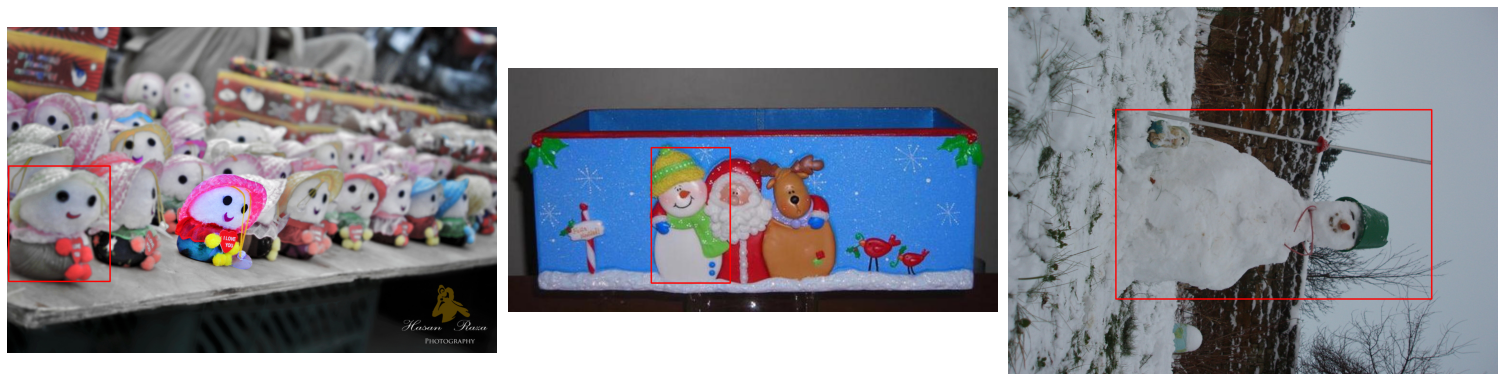

In [18]:
# Visualize a few training images.
plot(
    image_paths='/content/yolov5/snowman_data/images/train/*', 
    label_paths='/content/yolov5/snowman_data/labels/train/*',
    num_samples=3
)

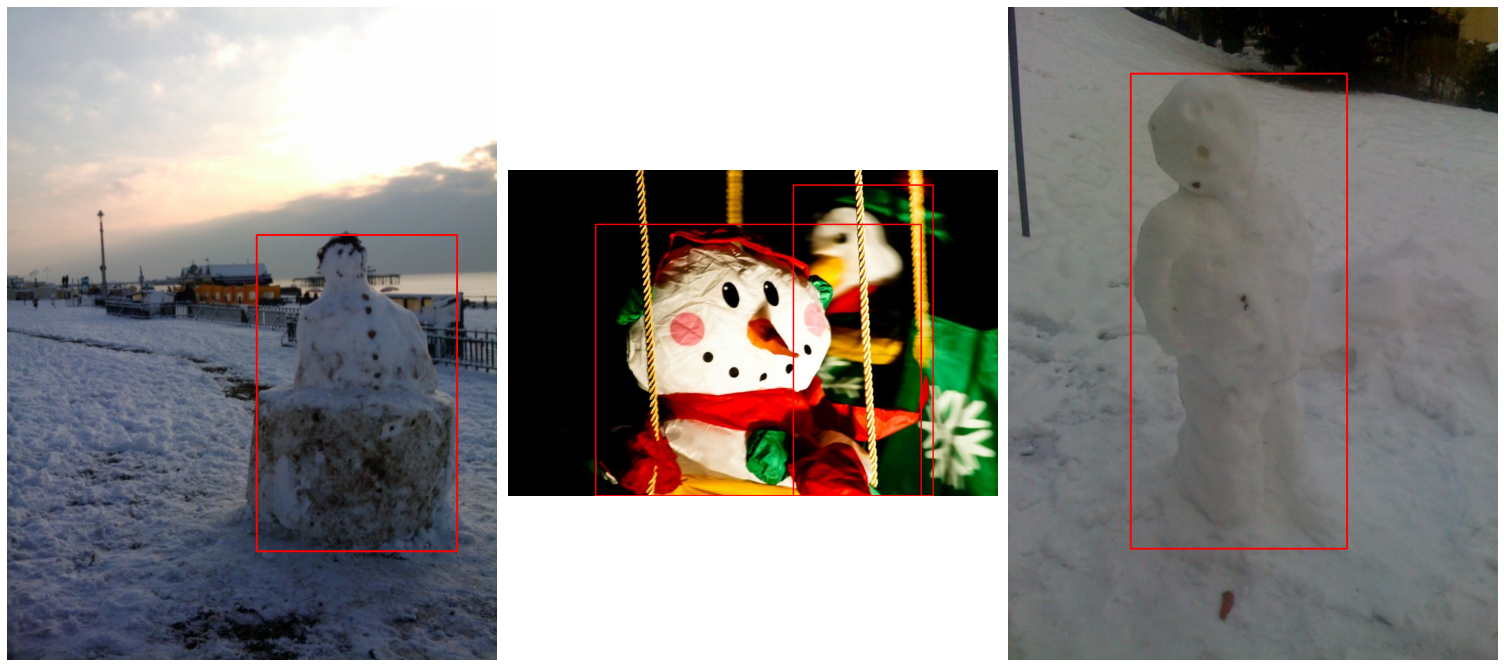

In [19]:
# Visualize a few validation images.
plot(
    image_paths='/content/yolov5/snowman_data/images/val/*', 
    label_paths='/content/yolov5/snowman_data/labels/val/*',
    num_samples=3
)

### Prepare the YAML File Containing the Paths for YOLOv5 Training

In [20]:
!ls data

Argoverse.yaml	GlobalWheat2020.yaml  Objects365.yaml  VisDrone.yaml
coco128.yaml	hyps		      scripts	       VOC.yaml
coco.yaml	images		      SKU-110K.yaml    xView.yaml


In [21]:
%%writefile data/snowman.yaml

path: snowman_data # dataset root dir
train: images/train  # train images (relative to 'path') 
val: images/val  # val images (relative to 'path')
test:  # test images (optional)

# Classes
nc: 1  # number of classes
names: ['snowman']  # class names

Writing data/snowman.yaml


In [22]:
!ls data

Argoverse.yaml	      hyps	       SKU-110K.yaml  xView.yaml
coco128.yaml	      images	       snowman.yaml
coco.yaml	      Objects365.yaml  VisDrone.yaml
GlobalWheat2020.yaml  scripts	       VOC.yaml


## Start the Training

In [23]:
#### CHOOSE BETWEEN Nano, Small, Regular, Large, and Xtra large Models.
!ls models/*.yaml

models/yolov5l.yaml  models/yolov5n.yaml  models/yolov5x.yaml
models/yolov5m.yaml  models/yolov5s.yaml


In [24]:
# Directory to store results
res_dir_count = len(glob.glob('runs/train/*'))
print(f"Current number of result directories: {res_dir_count}")

Current number of result directories: 0


In [25]:
if TRAIN:
    RES_DIR = f"results{res_dir_count+1}"
    print(RES_DIR)
else:
    RES_DIR = f"results{res_dir_count}"

results1


In [26]:
#### RUN THIS IF TRAINING GIVES REQUIREMENTS ERROR ####
!pip install -r requirements.txt

     |████████████████████████████████| 596 kB 5.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [27]:
### TRAINING A Medium MODEL ###
# The chosen pretrained model will be downloaded automatically.
if TRAIN:
    !python train.py --img 640 --batch 16 --epochs {EPOCHS} --data snowman.yaml --weights yolov5m.pt \
    --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 \
    --name {RES_DIR}

wandb: Currently logged in as: sovitrath (use `wandb login --relogin` to force relogin)
train: weights=yolov5m.pt, cfg=, data=snowman.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=results1, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-155-gdc54ed5 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, bo

## Check Out the Validation Predictions Saved During Training

In [28]:
!ls runs/train/{RES_DIR}

confusion_matrix.png				   results.csv
events.out.tfevents.1640162016.9350e24b78c0.275.0  results.png
F1_curve.png					   train_batch0.jpg
hyp.yaml					   train_batch1.jpg
labels_correlogram.jpg				   train_batch2.jpg
labels.jpg					   val_batch0_labels.jpg
opt.yaml					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   weights


**Each experiment will be stores in `results<num>` directory. The most recent experiment is stored in `results<highest_number>` folder. For example, `results1`, `results2`, `results3`, and so on**. 

In [29]:
!ls runs/train/{RES_DIR}

confusion_matrix.png				   results.csv
events.out.tfevents.1640162016.9350e24b78c0.275.0  results.png
F1_curve.png					   train_batch0.jpg
hyp.yaml					   train_batch1.jpg
labels_correlogram.jpg				   train_batch2.jpg
labels.jpg					   val_batch0_labels.jpg
opt.yaml					   val_batch0_pred.jpg
P_curve.png					   val_batch1_labels.jpg
PR_curve.png					   val_batch1_pred.jpg
R_curve.png					   weights


In [30]:
EXP_PATH = f"runs/train/{RES_DIR}"
validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
print(validation_pred_images)

['runs/train/results1/val_batch1_pred.jpg', 'runs/train/results1/val_batch0_pred.jpg']


In [31]:
for pred_image in validation_pred_images:
    image = cv2.imread(pred_image)
    plt.figure(figsize=(19, 16))
    plt.imshow(image[:, :, ::-1])
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Inference
In this section, we will carry out inference on unseen images and videos from the internet. 

The images for inference are in the `inference_images` directory.

The videos for inference are in the `inference_videos` directory.

### Download the Images and Videos
Let's download the images and videos that we will carry inference upon.

In [32]:
os.makedirs('inference_images', exist_ok=True)
os.makedirs('inference_videos', exist_ok=True)

In [33]:
download_file('https://learnopencv.s3.us-west-2.amazonaws.com/snowman1.jpg'
              , 'inference_images/image_1.jpg')
download_file('https://learnopencv.s3.us-west-2.amazonaws.com/snowman2.jpg'
              , 'inference_images/image_2.jpg')

download_file('https://learnopencv.s3.us-west-2.amazonaws.com/snowman_video.mp4'
              , 'inference_videos/video_1.mp4')

### Inference on Images

In [34]:
# Directory to store inference results
infer_dir_count = len(glob.glob('runs/detect/*'))
print(f"Current number of inference detection directories: {infer_dir_count}")
INFER_DIR = f"inference{infer_dir_count+1}"
print(INFER_DIR)

Current number of inference detection directories: 0
inference1


**For inference on images, we can just provide the directory path where all the images are stored, and inference will happen on all images automatically**.

In [35]:
# Inference on images.
!python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
--source inference_images --name {INFER_DIR}

detect: weights=['runs/train/results1/weights/best.pt'], source=inference_images, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference1, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-155-gdc54ed5 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/2 /content/yolov5/inference_images/image_1.jpg: 384x640 2 snowmans, Done. (0.053s)
image 2/2 /content/yolov5/inference_images/image_2.jpg: 352x640 4 snowmans, Done. (0.050s)
Speed: 0.6ms pre-process, 51.2ms inference, 6.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/inference1


In [36]:
# Visualize infernece images.
INFER_PATH = f"runs/detect/{INFER_DIR}"
infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
print(infer_images)

['runs/detect/inference1/image_1.jpg', 'runs/detect/inference1/image_2.jpg']


In [37]:
for pred_image in infer_images:
    image = cv2.imread(pred_image)
    plt.figure(figsize=(19, 16))
    plt.imshow(image[:, :, ::-1])
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Inference on Videos

In [38]:
# Directory to store inference results
infer_dir_count = len(glob.glob('runs/detect/*'))
print(f"Current number of inference detection directories: {infer_dir_count}")
INFER_DIR = f"inference{infer_dir_count+1}"
print(INFER_DIR)

Current number of inference detection directories: 1
inference2


In [39]:
# Inference on images.
!python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
--source inference_videos --name {INFER_DIR}

detect: weights=['runs/train/results1/weights/best.pt'], source=inference_videos, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=inference2, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-155-gdc54ed5 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
video 1/1 (1/300) /content/yolov5/inference_videos/video_1.mp4: 384x640 21 snowmans, Done. (0.065s)
video 1/1 (2/300) /content/yolov5/inference_videos/video_1.mp4: 384x640 15 snowmans, Done. (0.059s)
video 1/1 (3/300) /content/yolov5/inference_videos/video_1.mp4: 384x640 11 snowmans, Done. (0.059s)
video 1/1 (4/300) /content/yolov5/inference_videos/video_1.mp4: 384x640 10 snowmans, Do